Beginning of our project :)

Reading our Dataset Below:

In [56]:
#import sklearn.datasets
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import spacy
from pprint import pprint

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

#import mlflow
#from mlflow import log_metric, log_param, log_artifacts

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [57]:
MB_dataset = pd.read_csv('mbti_1.csv')
print(MB_dataset)
MB_dataset.describe()
MB_dataset.isnull().sum()

      type                                              posts
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1     ENTP  'I'm finding the lack of me in these posts ver...
2     INTP  'Good one  _____   https://www.youtube.com/wat...
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...
4     ENTJ  'You're fired.|||That's another silly misconce...
...    ...                                                ...
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...
8671  ENFP  'So...if this thread already exists someplace ...
8672  INTP  'So many questions when i do these things.  I ...
8673  INFP  'I am very conflicted right now when it comes ...
8674  INFP  'It has been too long since I have been on per...

[8675 rows x 2 columns]


type     0
posts    0
dtype: int64

In [58]:
personalities = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}
MB_dataset.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


<AxesSubplot: >

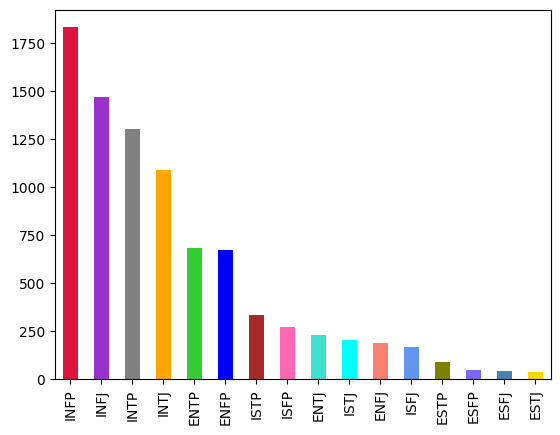

In [59]:
#make a bar chart of how often each personality type is mentioned in a post
MB_dataset["type"].value_counts()
colors = ['crimson', 'darkorchid', 'gray', 'orange', 'limegreen', 'blue', 'brown', 'hotpink', 'turquoise', 'cyan', 'salmon', 'cornflowerblue', 'olive', 'mediumslateblue', 'steelblue', 'gold']

MB_dataset["type"].value_counts().plot(kind="bar", color=['crimson', 'darkorchid', 'gray', 'orange', 'limegreen', 'blue', 'brown', 'hotpink', 'turquoise', 'cyan', 'salmon', 'cornflowerblue', 'olive', 'mediumslateblue', 'steelblue', 'gold' ])


In [60]:
cnt = MB_dataset.groupby(['type'])['posts'].count()
pie = go.Pie(labels=cnt.index, values=cnt.values)
fig = go.Figure(data=[pie])
py.iplot(fig)

In [61]:
lemmatiser = WordNetLemmatizer()
useless_words = stopwords.words("english")


In [62]:
def replace_symbols(text):
    text = re.sub('https?\S+', ' ', text) #Removing urls 
    text = re.sub("[^a-zA-Z]", " ", text) #Removing non-words
    text = re.sub(' +', ' ', text) #Removing consecutive whitespace
    text = " ".join([lemmatiser.lemmatize(w) for w in text.split(' ') if w not in useless_words])
    text = text.lower()
    pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
    pers_types = [p.lower() for p in pers_types]
    for t in pers_types:
        text = text.replace(t, "")
    p = re.compile("(" + "|".join(pers_types) + ")")
    return text

MB_dataset['cleaned_posts'] = MB_dataset['posts'].apply(replace_symbols)
MB_dataset.describe()
MB_dataset.head(10)


,type,posts,cleaned_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play prank what ...
1,ENTP,'I'm finding the lack of me in these posts ver...,i finding lack post alarming sex boring posit...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course i say i know blessing curse d...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear i enjoyed conversation day esoteric gab...
4,ENTJ,'You're fired.|||That's another silly misconce...,you fired that another silly misconception th...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...,science perfect no scientist claim scientific...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos...",no i draw nail haha those done professional n...
7,INTJ,'I tend to build up a collection of things on ...,i tend build collection thing desktop use fre...
8,INFJ,"I'm not sure, that's a good question. The dist...",i sure good question the distinction two depen...
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...,position i actually let go person due various...


In [63]:
print("\nPost before preprocessing:\n\n", MB_dataset['posts'][0])



Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010

In [64]:
print("\nPost after preprocessing:\n\n", MB_dataset['cleaned_posts'][0])



Post after preprocessing:

   moment sportscenter top ten play prank what life changing experience life on repeat today may perc experience immerse the last thing  friend posted facebook committing suicide next day rest peace  sorry hear distress it natural relationship perfection time every moment existence try figure hard time time growth welcome stuff game set match prozac wellbrutin least thirty minute moving leg i mean moving sitting desk chair weed moderation maybe try edible healthier alternative basically come three item determined type whichever type want would likely use given type cognitive function whatnot left all thing moderation sims indeed video game good one note good one somewhat subjective i completely promoting death given sim dear  what favorite video game growing current favorite video game cool appears late sad there someone everyone wait i thought confidence good thing i cherish time solitude b c revel within inner world whereas time workin enjoy time don worry

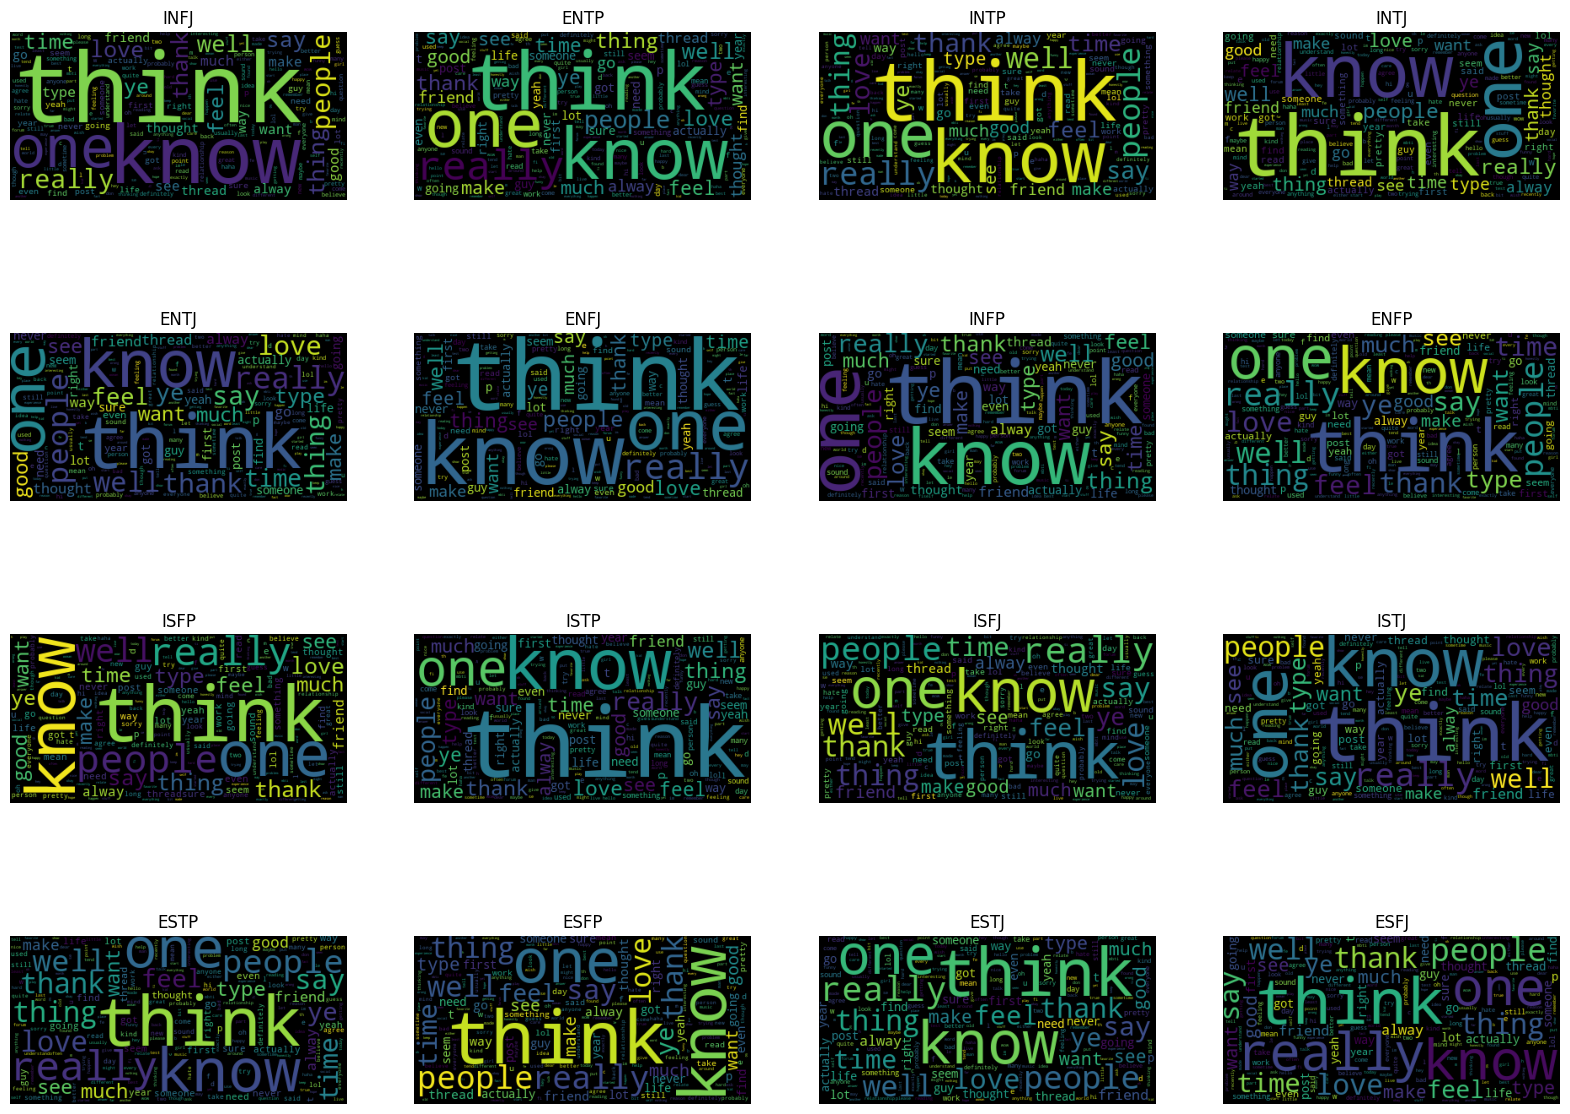

In [65]:
STOPWORDS.add('URL') # words to not consider
STOPWORDS.add('S')
labels = MB_dataset['type'].unique()
row, col = 4, 4
wc = WordCloud(stopwords=STOPWORDS)

fig, ax = plt.subplots(4, 4, figsize=(20,15))

for i in range(4):
    for j in range(4):
        cur_type = labels[i*col+j]
        cur_ax = ax[i][j]
        df = MB_dataset[MB_dataset['type'] == cur_type]
        wordcloud = wc.generate(MB_dataset['cleaned_posts'].to_string())
        cur_ax.imshow(wordcloud)
        cur_ax.axis('off')
        cur_ax.set_title(cur_type)

Feature Extraction

In [66]:
sw = MB_dataset.copy()

sw['words_per_comment'] = sw['cleaned_posts'].apply(lambda x: len(x.split())/50)
sw.head()

,type,posts,cleaned_posts,words_per_comment
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play prank what ...,6.36
1,ENTP,'I'm finding the lack of me in these posts ver...,i finding lack post alarming sex boring posit...,13.90
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course i say i know blessing curse d...,10.10
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear i enjoyed conversation day esoteric gab...,12.26
4,ENTJ,'You're fired.|||That's another silly misconce...,you fired that another silly misconception th...,11.32


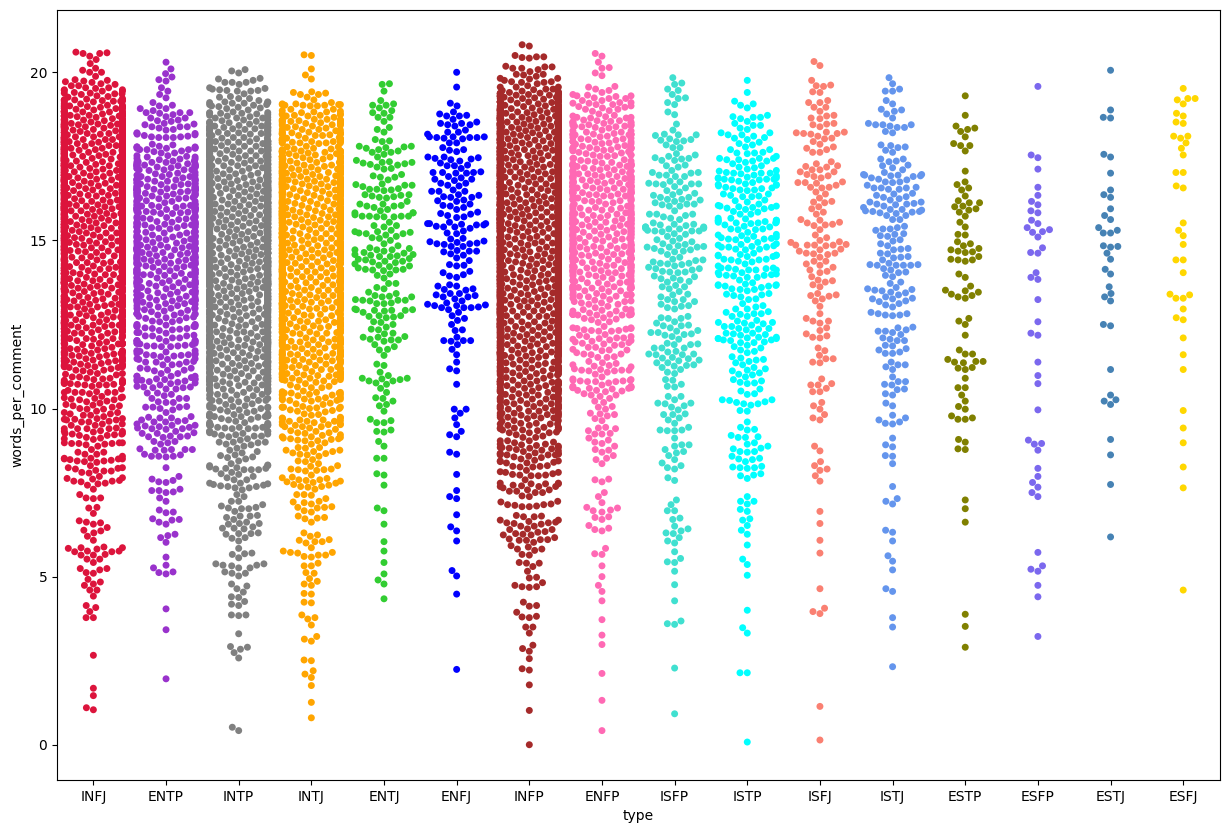

In [67]:
plt.figure(figsize=(15,10))
sns.swarmplot(data=sw, x="type", y="words_per_comment", palette = colors)
plt.show()

In [68]:
sw['E/I'] = sw['type'].apply(lambda x: x[0] == 'E').astype('int')
sw['S/N'] = sw['type'].apply(lambda x: x[1] == 'S').astype('int')
sw['T/F'] = sw['type'].apply(lambda x: x[2] == 'T').astype('int')
sw['J/P'] = sw['type'].apply(lambda x: x[3] == 'J').astype('int')
sw.head()

,type,posts,cleaned_posts,words_per_comment,E/I,S/N,T/F,J/P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play prank what ...,6.36,0,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,i finding lack post alarming sex boring posit...,13.90,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course i say i know blessing curse d...,10.10,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear i enjoyed conversation day esoteric gab...,12.26,0,0,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,you fired that another silly misconception th...,11.32,1,0,1,1


In [100]:
# # Create a TfidfVectorizer with better parameter usage and apply it to the data
TFIDF_vect = TfidfVectorizer(lowercase=True, stop_words='english', max_features=100)
all_data_TFIDF = TFIDF_vect.fit_transform(sw['cleaned_posts'])

# # Check the new TfidfVectorizer shape
all_data_TFIDF.shape


(8675, 500)

In [101]:
nlp = spacy.load("en_core_web_sm")


In [102]:
X = all_data_TFIDF # features
y = sw[['type']]  # labels
target_encoder=LabelEncoder()
y=target_encoder.fit_transform(y)

In [103]:
def split_data(X,y,scaled,split_rate):
    if (scaled):
        scaler = StandardScaler(with_mean = False)
        X = scaler.fit_transform(X)       
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_rate, random_state=42, stratify=y)
    strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True)
       
    return X_train, y_train, X_test, y_test

logistic_regression_classifier = LogisticRegression()
logistic_regression_classifier.fit(X_train, y_train)

logistic_regression_train_predictions = logistic_regression_classifier.predict(X_train)
logistic_regression_train_accuracy = accuracy_score(y_train, logistic_regression_train_predictions)
print("Train accuracy: ", round(logistic_regression_train_accuracy, 3))

logistic_regression_predictions = logistic_regression_classifier.predict(X_test)
logistic_regression_accuracy = accuracy_score(y_test, logistic_regression_predictions)
print("Test accuracy: ", round(logistic_regression_accuracy, 3))

accuracy = np.mean(cross_val_score(LogisticRegression(), X_train, y_train, cv=strat_k_fold, scoring='accuracy', n_jobs=-1))
print("CV accuracy: ", round(accuracy, 3))

In [104]:
def SVM(X_train,y_train,X_test,y_test):
    model_svc=SVC()
    model_svc.fit(X_train,y_train)
    prediction_train = model_svc.predict(X_train)
    prediction_test = model_svc.predict(X_test)
    create_report(y_train, y_test, prediction_train, prediction_test)

model_multinomial_nb=MultinomialNB()
model_multinomial_nb.fit(X_train,y_train)
print('train classification report \n ',classification_report(y_train,model_multinomial_nb.predict(X_train),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(y_test,model_multinomial_nb.predict(X_test),target_names=target_encoder.inverse_transform([i for i in range(16)])))

model_forest=RandomForestClassifier(max_depth=10)
model_forest.fit(X_train,y_train)
print('train classification report \n ',classification_report(y_train,model_forest.predict(X_train),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(y_test,model_forest.predict(X_test),target_names=target_encoder.inverse_transform([i for i in range(16)])))

model_xgb=XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.1)
model_xgb.fit(X_train,y_train)
print('train classification report \n ',classification_report(y_train,model_xgb.predict(X_train),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(y_test,model_xgb.predict(X_test),target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [105]:
#model_cat=CatBoostClassifier(depth = 3, loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU',verbose=False)
#model_cat.fit(X_train,y_train)
#print('train classification report \n ',classification_report(y_train,model_cat.predict(X_train),target_names=target_encoder.inverse_transform([i for i in range(16)])))
#print('test classification report \n ',classification_report(y_test,model_cat.predict(X_test),target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [106]:
def create_report(y_train, y_test, prediction_train, prediction_test):
    print('train classification report \n ',classification_report(y_train,prediction_train,target_names=target_encoder.inverse_transform([i for i in range(16)])))
    print('test classification report \n ',classification_report(y_test,prediction_test,target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [107]:
def main():
    global X,y
    X_train,y_train,X_test,y_test = split_data(X,y,'false',0.2)
    SVM(X_train,y_train,X_test,y_test)

In [108]:
main()

train classification report 
                precision    recall  f1-score   support

        ENFJ       1.00      0.04      0.08       152
        ENFP       0.89      0.70      0.78       540
        ENTJ       1.00      0.37      0.54       185
        ENTP       0.89      0.82      0.86       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.10      0.18        71
        INFJ       0.75      0.90      0.82      1176
        INFP       0.68      0.97      0.80      1466
        INTJ       0.82      0.88      0.85       873
        INTP       0.79      0.91      0.84      1043
        ISFJ       1.00      0.18      0.31       133
        ISFP       1.00      0.20      0.34       217
        ISTJ       1.00      0.28      0.44       164
        ISTP       1.00      0.63      0.77       270

    accuracy                           0.78      